# Fine-tuning a Pretrained Network for Style Recognition

First, we will need to prepare the data. This involves the following parts:
* Get the ImageNet ilsvrc pretrained model with the provided shell scripts.
* Download a subset of the overall Flickr style dataset for this demo.
* Compile the downloaded Flickr dataset into a database that Caffe can then consume.

In [1]:
!ls ../caffe/python

CMakeLists.txt	caffe  classify.py  detect.py  draw_net.py  requirements.txt


In [2]:
import os
caffe_root = '/home/cudacaffe/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
assert os.path.exists(caffe_root)

In [3]:
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
import time

caffe.set_device(0)
caffe.set_mode_gpu()

import numpy as np
from pylab import *
%matplotlib inline
import tempfile

In [4]:
# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

### 1. Setup and dataset download

Download data required for this exercise.

- `get_ilsvrc_aux.sh` to download the ImageNet data mean, labels, etc.
- `download_model_binary.py` to download the pretrained reference model
- `finetune_flickr_style/assemble_data.py` downloadsd the style training and testing data

We'll download just a small subset of the full dataset for this exercise: just 2000 of the 80K images, from 5 of the 20 style categories.  (To download the full dataset, set `full_dataset = True` in the cell below.)

In [5]:
# Download just a small subset of the data for this exercise.
# (2000 of 80K images, 5 of 20 labels.)
# To download the entire dataset, set `full_dataset = True`.
full_dataset = False
if full_dataset:
    NUM_STYLE_IMAGES = NUM_STYLE_LABELS = -1
else:
    NUM_STYLE_IMAGES = 2000
    NUM_STYLE_LABELS = 5

# This downloads the ilsvrc auxiliary data (mean file, etc),
# and a subset of 2000 images for the style recognition task.

import os
os.chdir(caffe_root)  # run scripts from caffe root

if (not os.path.exists('data/ilsvrc12/synset_words.txt')) or \
   (not os.path.exists('examples/finetune_flickr_style/style_names.txt')):

    !data/ilsvrc12/get_ilsvrc_aux.sh
    !scripts/download_model_binary.py models/bvlc_reference_caffenet
    !python examples/finetune_flickr_style/assemble_data.py \
        --workers=-1  --seed=1701 \
        --images=$NUM_STYLE_IMAGES  --label=$NUM_STYLE_LABELS
else:
    print('models and meta data exist')
# move to example directory 
os.chdir('examples')

models and meta data exist


In [6]:
import os
weights = os.path.join(caffe_root, 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
assert os.path.exists(weights)

Load the 1000 ImageNet labels from `ilsvrc12/synset_words.txt`, and the 5 style labels from `finetune_flickr_style/style_names.txt`.

In [7]:
# Load ImageNet labels to imagenet_labels
imagenet_label_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
assert len(imagenet_labels) == 1000
print 'Loaded ImageNet labels:\n', '\n'.join(imagenet_labels[:10] + ['...'])

# Load style labels to style_labels
style_label_file = caffe_root + 'examples/finetune_flickr_style/style_names.txt'
style_labels = list(np.loadtxt(style_label_file, str, delimiter='\n'))
if NUM_STYLE_LABELS > 0:
    style_labels = style_labels[:NUM_STYLE_LABELS]
print '\nLoaded style labels:\n', ', '.join(style_labels)

Loaded ImageNet labels:
n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
n01494475 hammerhead, hammerhead shark
n01496331 electric ray, crampfish, numbfish, torpedo
n01498041 stingray
n01514668 cock
n01514859 hen
n01518878 ostrich, Struthio camelus
...

Loaded style labels:
Detailed, Pastel, Melancholy, Noir, HDR


### 2.  Defining and running the nets

We'll start by defining `caffenet`, a function which initializes the *CaffeNet* architecture (a minor variant on *AlexNet*), taking arguments specifying the data and number of output classes.

In [8]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        return f.name

Define a function `style_net` which calls `caffenet` on data from the Flickr style dataset.

The new network will also have the *CaffeNet* architecture, with differences in the input and output:

- the input is the Flickr style data we downloaded, provided by an `ImageData` layer
- the output is a distribution over 20 classes rather than the original 1000 ImageNet classes
- the classification layer is renamed from `fc8` to `fc8_flickr` to tell Caffe not to load the original classifier (`fc8`) weights from the ImageNet-pretrained model

In [9]:
def style_net(train=True, learn_all=False, subset=None):
    if subset is None:
        subset = 'train' if train else 'test'
    source = caffe_root + 'data/flickr_style/%s.txt' % subset
    transform_param = dict(mirror=train, crop_size=227,
        mean_file=caffe_root + 'data/ilsvrc12/imagenet_mean.binaryproto')
    style_data, style_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=50, new_height=256, new_width=256, ntop=2)
    return caffenet(data=style_data, label=style_label, train=train,
                    num_classes=NUM_STYLE_LABELS,
                    classifier_name='fc8_flickr',
                    learn_all=learn_all)

In [10]:
def disp_preds(net, image, labels, k=5, name='ImageNet'):
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    print 'top %d predicted %s labels =' % (k, name)
    print '\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k))

def disp_imagenet_preds(net, image):
    disp_preds(net, image, imagenet_labels, name='ImageNet')

def disp_style_preds(net, image):
    disp_preds(net, image, style_labels, name='style')

### 3. Training the style classifier

Now, we'll define a function `solver` to create our Caffe solvers, which are used to train the network (learn its weights).  In this function we'll set values for various parameters used for learning, display, and "snapshotting" -- see the inline comments for explanations of what they mean.  You may want to play with some of the learning parameters to see if you can improve on the results here!

In [11]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = caffe_root + 'models/finetune_flickr_style/finetune_flickr_style'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

In [12]:
def run_solvers(niter, solvers, disp_interval=1000):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

In [13]:

niter = 500  # number of iterations to train

# Reset style_solver as before.
style_solver_filename = solver(style_net(train=True))
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(weights)

# For reference, we also create a solver that isn't initialized from
# the pretrained ImageNet weights.
scratch_style_solver_filename = solver(style_net(train=True))
scratch_style_solver = caffe.get_solver(scratch_style_solver_filename)

print 'solvers for %d iterations...' % niter
solvers = [('pretrained', style_solver),
           ('scratch', scratch_style_solver)]

loss, acc, weights = run_solvers(niter, solvers)

print 'Done.'

train_loss, scratch_train_loss = loss['pretrained'], loss['scratch']
train_acc, scratch_train_acc = acc['pretrained'], acc['scratch']
style_weights, scratch_style_weights = weights['pretrained'], weights['scratch']

# Delete solvers to save memory.
del style_solver, scratch_style_solver, solvers

solvers for 500 iterations...
  0) pretrained: loss=1.609, acc=30%; scratch: loss=1.609, acc=30%
499) pretrained: loss=1.170, acc=62%; scratch: loss=1.602, acc=14%
Done.


Let's look at the training loss and accuracy produced by the two training procedures.  Notice how quickly the ImageNet pretrained model's loss value (blue) drops, and that the randomly initialized model's loss value (green) barely (if at all) improves from training only the classifier layer.

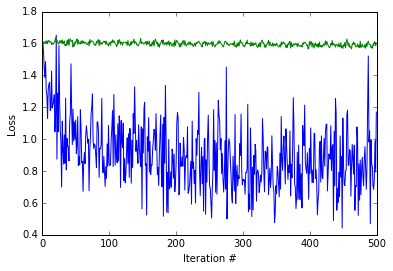

In [14]:
plot(np.vstack([train_loss, scratch_train_loss]).T)
xlabel('Iteration #')
ylabel('Loss')

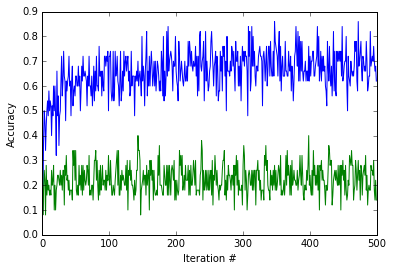

In [15]:
plot(np.vstack([train_acc, scratch_train_acc]).T)
xlabel('Iteration #')
ylabel('Accuracy')

In [16]:
def eval_style_net(weights, test_iters=10):
    test_net = caffe.Net(style_net(train=False), weights, caffe.TEST)
    accuracy = 0
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
    accuracy /= test_iters
    return test_net, accuracy

In [17]:
test_net, accuracy = eval_style_net(style_weights, test_iters=100)
print 'Accuracy, trained from ImageNet initialization: %3.1f%%' % (100*accuracy, )
scratch_test_net, scratch_accuracy = eval_style_net(scratch_style_weights)
print 'Accuracy, trained from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

Accuracy, trained from ImageNet initialization: 52.4%
Accuracy, trained from   random initialization: 23.6%


# Profiling performance (speed)

In [18]:
weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

niter = 500  # number of iterations to train

# Reset style_solver as before.
style_solver_filename = solver(style_net(train=True))
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(weights)

# For reference, we also create a solver that isn't initialized from
# the pretrained ImageNet weights.
scratch_style_solver_filename = solver(style_net(train=True))
scratch_style_solver = caffe.get_solver(scratch_style_solver_filename)

print 'solvers for %d iterations...' % niter
solvers = [('pretrained', style_solver),
           ('scratch', scratch_style_solver)]


solvers for 500 iterations...


In [19]:
# training
%timeit run_solvers(niter, solvers)

  0) pretrained: loss=1.609, acc=30%; scratch: loss=1.609, acc=30%
499) pretrained: loss=0.731, acc=74%; scratch: loss=1.592, acc=16%
  0) pretrained: loss=0.901, acc=64%; scratch: loss=1.589, acc=24%
499) pretrained: loss=0.741, acc=74%; scratch: loss=1.582, acc=26%
  0) pretrained: loss=0.762, acc=80%; scratch: loss=1.583, acc=28%
499) pretrained: loss=0.774, acc=72%; scratch: loss=1.528, acc=42%
  0) pretrained: loss=0.655, acc=78%; scratch: loss=1.523, acc=38%
499) pretrained: loss=0.631, acc=70%; scratch: loss=1.522, acc=34%
1 loop, best of 3: 1min 22s per loop


In [20]:
# testing
%timeit eval_style_net(style_weights, test_iters=100)

1 loop, best of 3: 17.1 s per loop


**Observation**: We get similar performance on the docker container on host in terms of runtime